In [1]:
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("eth-mtc/aesthetics")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })



In [2]:
def get_info(row):
    
    metric_names = ['SRCC', 'LCC', 'MSE', 'accuracy']
    results = {k: row.summary[k] for k in metric_names}
    
    config_names = ['run_name', 'dataset', 'model_name', 'num_epochs']
    if row.config['model_name'] in row.run_name or row.config['dataset'] == 'dummy':
        return None
    results.update({k: row.config[k] for k in config_names})
    results['scoring'] = results['run_name'].split('-')[0]
    
    return results
info = runs_df[runs_df.summary.apply(lambda x: 'SRCC' in x)].rename(columns={'name': 'run_name'}).apply(get_info, axis=1)
info = pd.DataFrame(list(info[info.notna()]))
info


,SRCC,LCC,MSE,accuracy,run_name,dataset,model_name,num_epochs,scoring
0,0.765074,0.768167,0.2332,0.819488,baseline-vit_deit_base_patch16_224-c2bc5e5,ava,vit_deit_base_patch16_224,5,baseline
1,0.541824,0.551132,2.0362,0.905007,sentiment-vit_large_patch16_224-c2bc5e5,ava,vit_large_patch16_224,3,sentiment
2,0.544161,0.550186,2.0893,0.905461,sentiment-vit_large_patch16_224_in21k-c2bc5e5,ava,vit_large_patch16_224_in21k,3,sentiment
3,0.215917,0.218063,6.0620,0.646199,baseline-vit_deit_base_patch16_224-c2bc5e5,reddit,vit_deit_base_patch16_224,5,baseline
4,0.793684,0.793142,0.2129,0.828488,baseline-vit_large_patch16_224_in21k-777b618,ava,vit_large_patch16_224_in21k,3,baseline
5,0.53316,0.542008,2.0829,0.904755,sentiment-vit_base_patch16_224_in21k-c2bc5e5,ava,vit_base_patch16_224_in21k,5,sentiment
6,0.526935,0.53388,2.0895,0.904603,sentiment-vit_base_patch16_224-c2bc5e5,ava,vit_base_patch16_224,5,sentiment
7,0.499706,0.512939,2.1486,0.904856,sentiment-vit_deit_small_patch16_224-c2bc5e5,ava,vit_deit_small_patch16_224,5,sentiment
8,0.249581,0.253238,5.9399,0.652698,baseline-vit_large_patch16_224-c2bc5e5,reddit,vit_large_patch16_224,3,baseline
9,0.246097,0.246042,5.9647,0.650802,baseline-vit_large_patch16_224_in21k-c2bc5e5,reddit,vit_large_patch16_224_in21k,3,baseline


In [3]:
# Filter out runs with not scaled sentiment score
info = info[info.MSE > 0.1]
# Clean SRCC and LCC
info.SRCC = info.SRCC.apply(lambda x: x[0] if isinstance(x,list) else x)
info.LCC = info.LCC.apply(lambda x: x[0] if isinstance(x,list) else x)
info

/tmp/ipykernel_10740/981811963.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info.SRCC = info.SRCC.apply(lambda x: x[0] if isinstance(x,list) else x)
/tmp/ipykernel_10740/981811963.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info.LCC = info.LCC.apply(lambda x: x[0] if isinstance(x,list) else x)


,SRCC,LCC,MSE,accuracy,run_name,dataset,model_name,num_epochs,scoring
0,0.765074,0.768167,0.2332,0.819488,baseline-vit_deit_base_patch16_224-c2bc5e5,ava,vit_deit_base_patch16_224,5,baseline
1,0.541824,0.551132,2.0362,0.905007,sentiment-vit_large_patch16_224-c2bc5e5,ava,vit_large_patch16_224,3,sentiment
2,0.544161,0.550186,2.0893,0.905461,sentiment-vit_large_patch16_224_in21k-c2bc5e5,ava,vit_large_patch16_224_in21k,3,sentiment
3,0.215917,0.218063,6.0620,0.646199,baseline-vit_deit_base_patch16_224-c2bc5e5,reddit,vit_deit_base_patch16_224,5,baseline
4,0.793684,0.793142,0.2129,0.828488,baseline-vit_large_patch16_224_in21k-777b618,ava,vit_large_patch16_224_in21k,3,baseline
5,0.533160,0.542008,2.0829,0.904755,sentiment-vit_base_patch16_224_in21k-c2bc5e5,ava,vit_base_patch16_224_in21k,5,sentiment
6,0.526935,0.533880,2.0895,0.904603,sentiment-vit_base_patch16_224-c2bc5e5,ava,vit_base_patch16_224,5,sentiment
7,0.499706,0.512939,2.1486,0.904856,sentiment-vit_deit_small_patch16_224-c2bc5e5,ava,vit_deit_small_patch16_224,5,sentiment
8,0.249581,0.253238,5.9399,0.652698,baseline-vit_large_patch16_224-c2bc5e5,reddit,vit_large_patch16_224,3,baseline
9,0.246097,0.246042,5.9647,0.650802,baseline-vit_large_patch16_224_in21k-c2bc5e5,reddit,vit_large_patch16_224_in21k,3,baseline


In [4]:
param_number = {
    #https://github.com/facebookresearch/deit/blob/main/README_deit.md
    'vit_deit_tiny_patch16_224':5e6,
    'vit_deit_small_patch16_224':22e6,
    'vit_deit_base_patch16_224':86e6,
    #https://arxiv.org/pdf/2106.10270.pdf
    'vit_tiny_patch16_224':5.8e6,
    'vit_small_patch16_224':22.2e6,
    'vit_base_patch16_224':86e6,
    'vit_base_patch32_224':86e6,
    'vit_base_patch16_224_in21k':86e6,
    'vit_large_patch16_224':307e6,
    'vit_large_patch16_224_in21k':307e6,
    'cnn':13.5e6
}

In [5]:
info['#params'] = info.model_name.apply(lambda x: param_number[x])
info

/tmp/ipykernel_10740/1186773069.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info['#params'] = info.model_name.apply(lambda x: param_number[x])


,SRCC,LCC,MSE,accuracy,run_name,dataset,model_name,num_epochs,scoring,#params
0,0.765074,0.768167,0.2332,0.819488,baseline-vit_deit_base_patch16_224-c2bc5e5,ava,vit_deit_base_patch16_224,5,baseline,86000000.0
1,0.541824,0.551132,2.0362,0.905007,sentiment-vit_large_patch16_224-c2bc5e5,ava,vit_large_patch16_224,3,sentiment,307000000.0
2,0.544161,0.550186,2.0893,0.905461,sentiment-vit_large_patch16_224_in21k-c2bc5e5,ava,vit_large_patch16_224_in21k,3,sentiment,307000000.0
3,0.215917,0.218063,6.0620,0.646199,baseline-vit_deit_base_patch16_224-c2bc5e5,reddit,vit_deit_base_patch16_224,5,baseline,86000000.0
4,0.793684,0.793142,0.2129,0.828488,baseline-vit_large_patch16_224_in21k-777b618,ava,vit_large_patch16_224_in21k,3,baseline,307000000.0
5,0.533160,0.542008,2.0829,0.904755,sentiment-vit_base_patch16_224_in21k-c2bc5e5,ava,vit_base_patch16_224_in21k,5,sentiment,86000000.0
6,0.526935,0.533880,2.0895,0.904603,sentiment-vit_base_patch16_224-c2bc5e5,ava,vit_base_patch16_224,5,sentiment,86000000.0
7,0.499706,0.512939,2.1486,0.904856,sentiment-vit_deit_small_patch16_224-c2bc5e5,ava,vit_deit_small_patch16_224,5,sentiment,22000000.0
8,0.249581,0.253238,5.9399,0.652698,baseline-vit_large_patch16_224-c2bc5e5,reddit,vit_large_patch16_224,3,baseline,307000000.0
9,0.246097,0.246042,5.9647,0.650802,baseline-vit_large_patch16_224_in21k-c2bc5e5,reddit,vit_large_patch16_224_in21k,3,baseline,307000000.0


<AxesSubplot:xlabel='num_epochs'>

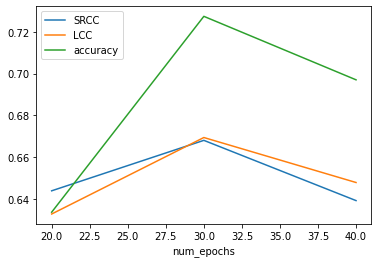

In [6]:
info[info.model_name == 'cnn'].plot(x='num_epochs', y=['SRCC', 'LCC', 'accuracy'])

In [12]:
ava_baseline = info[(info.dataset == 'ava') & (info.model_name != 'cnn') & (info.scoring=='baseline')].sort_values(by='#params')
ava_baseline['architecture'] = ava_baseline.apply(lambda x: 1 if 'deit' in x.model_name else 0, axis=1)
ava_baseline

,SRCC,LCC,MSE,accuracy,run_name,dataset,model_name,num_epochs,scoring,#params,architecture
44,0.725814,0.731069,0.2638,0.803390,baseline-33c673e,ava,vit_deit_tiny_patch16_224,5,baseline,5000000.0,1
41,0.746094,0.750227,0.2492,0.809023,baseline-33c673e,ava,vit_deit_small_patch16_224,5,baseline,22000000.0,1
40,0.734362,0.738180,0.2581,0.810079,baseline-33c673e,ava,vit_small_patch16_224,5,baseline,22200000.0,0
0,0.765074,0.768167,0.2332,0.819488,baseline-vit_deit_base_patch16_224-c2bc5e5,ava,vit_deit_base_patch16_224,5,baseline,86000000.0,1
38,0.759713,0.762053,0.2375,0.813852,baseline-33c673e,ava,vit_base_patch16_224,5,baseline,86000000.0,0
39,0.773021,0.774752,0.2297,0.819133,baseline-33c673e,ava,vit_base_patch16_224_in21k,5,baseline,86000000.0,0
43,0.446873,0.464801,0.4459,0.739312,baseline-33c673e,ava,vit_base_patch32_224,5,baseline,86000000.0,0
4,0.793684,0.793142,0.2129,0.828488,baseline-vit_large_patch16_224_in21k-777b618,ava,vit_large_patch16_224_in21k,3,baseline,307000000.0,0


In [8]:
ava = info[(info.dataset == 'ava') & (info.model_name != 'cnn')].sort_values(by='#params')
ava['model'] = ava.apply(lambda x: 'deit' if 'deit' in x.model_name else 'vit', axis=1)
ava['model'] = ava.apply(lambda x: 'vit_21k' if '21k' in x.model_name else x.model , axis=1)
ava['model'] = ava.apply(lambda x: 'vit_p32' if '32' in x.model_name else x.model , axis=1)
ava

,SRCC,LCC,MSE,accuracy,run_name,dataset,model_name,num_epochs,scoring,#params,model
15,0.492166,0.506838,2.1660,0.904654,sentiment-vit_deit_tiny_patch16_224-7687f38,ava,vit_deit_tiny_patch16_224,5,sentiment,5000000.0,deit
44,0.725814,0.731069,0.2638,0.803390,baseline-33c673e,ava,vit_deit_tiny_patch16_224,5,baseline,5000000.0,deit
7,0.499706,0.512939,2.1486,0.904856,sentiment-vit_deit_small_patch16_224-c2bc5e5,ava,vit_deit_small_patch16_224,5,sentiment,22000000.0,deit
41,0.746094,0.750227,0.2492,0.809023,baseline-33c673e,ava,vit_deit_small_patch16_224,5,baseline,22000000.0,deit
10,0.497613,0.512240,2.1541,0.904149,sentiment-vit_small_patch16_224-c2bc5e5,ava,vit_small_patch16_224,5,sentiment,22200000.0,vit
40,0.734362,0.738180,0.2581,0.810079,baseline-33c673e,ava,vit_small_patch16_224,5,baseline,22200000.0,vit
0,0.765074,0.768167,0.2332,0.819488,baseline-vit_deit_base_patch16_224-c2bc5e5,ava,vit_deit_base_patch16_224,5,baseline,86000000.0,deit
5,0.533160,0.542008,2.0829,0.904755,sentiment-vit_base_patch16_224_in21k-c2bc5e5,ava,vit_base_patch16_224_in21k,5,sentiment,86000000.0,vit_21k
6,0.526935,0.533880,2.0895,0.904603,sentiment-vit_base_patch16_224-c2bc5e5,ava,vit_base_patch16_224,5,sentiment,86000000.0,vit
13,0.266851,0.275514,2.6925,0.902736,sentiment-vit_base_patch32_224-c2bc5e5,ava,vit_base_patch32_224,5,sentiment,86000000.0,vit_p32


<AxesSubplot:xlabel='#params', ylabel='accuracy'>

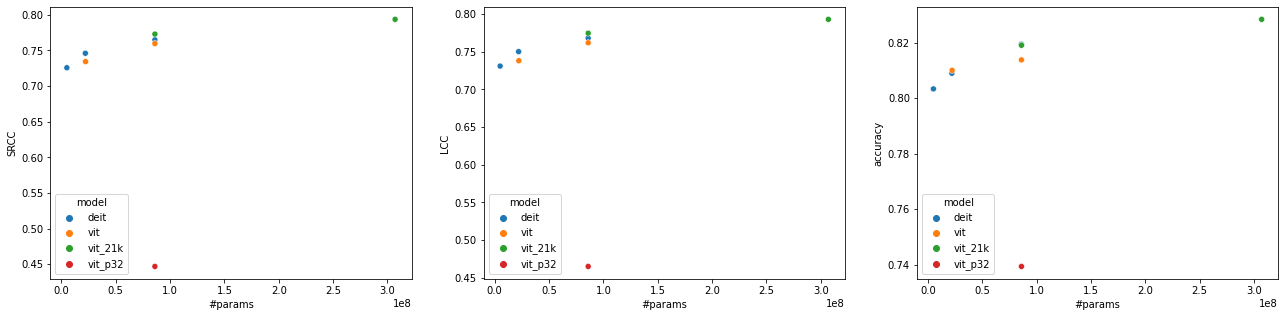

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, figsize=(22,5))
sns.scatterplot(data=ava[ava.scoring=='baseline'], x='#params', y='SRCC', hue='model', ax=axs[0])
sns.scatterplot(data=ava[ava.scoring=='baseline'], x='#params', y='LCC', hue='model', ax=axs[1])
sns.scatterplot(data=ava[ava.scoring=='baseline'], x='#params', y='accuracy', hue='model', ax=axs[2])


<AxesSubplot:xlabel='#params', ylabel='accuracy'>

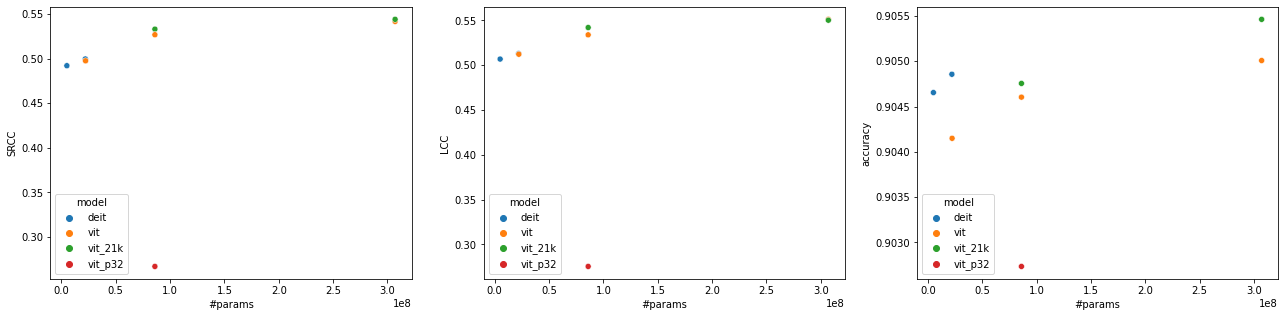

In [10]:
fig, axs = plt.subplots(ncols=3, figsize=(22,5))
sns.scatterplot(data=ava[ava.scoring=='sentiment'], x='#params', y='SRCC', hue='model', ax=axs[0])
sns.scatterplot(data=ava[ava.scoring=='sentiment'], x='#params', y='LCC', hue='model', ax=axs[1])
sns.scatterplot(data=ava[ava.scoring=='sentiment'], x='#params', y='accuracy', hue='model', ax=axs[2])

In [11]:
reddit = info[(info.dataset == 'reddit') & (info.model_name != 'cnn')].sort_values(by='#params')
reddit['model'] = reddit.apply(lambda x: 'deit' if 'deit' in x.model_name else 'vit', axis=1)
reddit['model'] = reddit.apply(lambda x: 'vit_21k' if '21k' in x.model_name else x.model , axis=1)
reddit['model'] = reddit.apply(lambda x: 'vit_p32' if '32' in x.model_name else x.model , axis=1)

reddit

,SRCC,LCC,MSE,accuracy,run_name,dataset,model_name,num_epochs,scoring,#params,model
18,0.188258,0.188810,6.1185,0.646808,baseline-vit_deit_tiny_patch16_224-c2bc5e5,reddit,vit_deit_tiny_patch16_224,5,baseline,5000000.0,deit
16,0.190077,0.189098,6.1495,0.646131,baseline-vit_deit_small_patch16_224-c2bc5e5,reddit,vit_deit_small_patch16_224,5,baseline,22000000.0,deit
14,0.201796,0.199314,6.1265,0.646537,baseline-vit_small_patch16_224-c2bc5e5,reddit,vit_small_patch16_224,5,baseline,22200000.0,vit
3,0.215917,0.218063,6.0620,0.646199,baseline-vit_deit_base_patch16_224-c2bc5e5,reddit,vit_deit_base_patch16_224,5,baseline,86000000.0,deit
11,0.229724,0.230057,6.0118,0.650058,baseline-vit_base_patch16_224-c2bc5e5,reddit,vit_base_patch16_224,5,baseline,86000000.0,vit
12,0.227872,0.228213,6.0481,0.647350,baseline-vit_base_patch16_224_in21k-c2bc5e5,reddit,vit_base_patch16_224_in21k,5,baseline,86000000.0,vit_21k
17,0.095530,0.091479,6.2924,0.642678,baseline-vit_base_patch32_224-c2bc5e5,reddit,vit_base_patch32_224,5,baseline,86000000.0,vit_p32
8,0.249581,0.253238,5.9399,0.652698,baseline-vit_large_patch16_224-c2bc5e5,reddit,vit_large_patch16_224,3,baseline,307000000.0,vit
9,0.246097,0.246042,5.9647,0.650802,baseline-vit_large_patch16_224_in21k-c2bc5e5,reddit,vit_large_patch16_224_in21k,3,baseline,307000000.0,vit_21k


<AxesSubplot:xlabel='#params', ylabel='accuracy'>

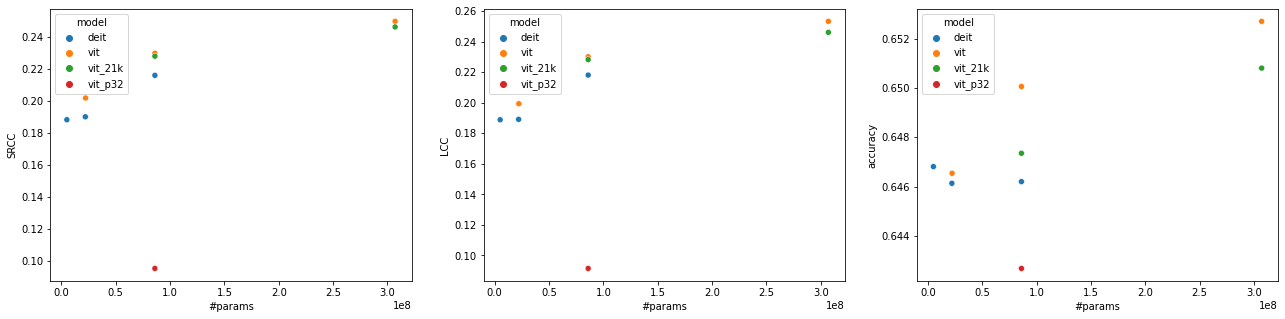

In [12]:
fig, axs = plt.subplots(ncols=3, figsize=(22,5))
sns.scatterplot(data=reddit[reddit.scoring=='baseline'], x='#params', y='SRCC', hue='model', ax=axs[0])
sns.scatterplot(data=reddit[reddit.scoring=='baseline'], x='#params', y='LCC', hue='model', ax=axs[1])
sns.scatterplot(data=reddit[reddit.scoring=='baseline'], x='#params', y='accuracy', hue='model', ax=axs[2])

In [13]:
PCCD = info[(info.dataset == 'PCCD') & (info.model_name != 'cnn')].sort_values(by='#params')
PCCD['model'] = PCCD.apply(lambda x: 'deit' if 'deit' in x.model_name else 'vit', axis=1)
PCCD['model'] = PCCD.apply(lambda x: 'vit_21k' if '21k' in x.model_name else x.model , axis=1)
PCCD['model'] = PCCD.apply(lambda x: 'vit_p32' if '32' in x.model_name else x.model , axis=1)

PCCD

,SRCC,LCC,MSE,accuracy,run_name,dataset,model_name,num_epochs,scoring,#params,model
22,0.186705,0.219904,2.0890,0.938679,sentiment-vit_deit_tiny_patch16_224-896480b,PCCD,vit_deit_tiny_patch16_224,15,sentiment,5000000.0,deit
34,0.226868,0.262430,1.4341,0.983412,baseline-vit_deit_tiny_patch16_224-896480b,PCCD,vit_deit_tiny_patch16_224,15,baseline,5000000.0,deit
19,0.169612,0.182382,2.0370,0.938679,sentiment-vit_deit_small_patch16_224-896480b,PCCD,vit_deit_small_patch16_224,15,sentiment,22000000.0,deit
32,0.288831,0.296054,1.3513,0.983412,baseline-vit_deit_small_patch16_224-896480b,PCCD,vit_deit_small_patch16_224,15,baseline,22000000.0,deit
20,0.191914,0.210781,2.0369,0.937500,sentiment-vit_small_patch16_224-896480b,PCCD,vit_small_patch16_224,15,sentiment,22200000.0,vit
31,0.277235,0.292796,1.3542,0.982227,baseline-vit_small_patch16_224-896480b,PCCD,vit_small_patch16_224,15,baseline,22200000.0,vit
21,0.048320,0.030855,2.0732,0.938679,sentiment-vit_base_patch32_224-896480b,PCCD,vit_base_patch32_224,15,sentiment,86000000.0,vit_p32
27,0.228553,0.261732,1.9564,0.938679,sentiment-vit_base_patch16_224-896480b,PCCD,vit_base_patch16_224,15,sentiment,86000000.0,vit
28,0.206127,0.224730,1.9783,0.938679,sentiment-vit_base_patch16_224_in21k-896480b,PCCD,vit_base_patch16_224_in21k,15,sentiment,86000000.0,vit_21k
29,0.281759,0.322287,1.2996,0.983412,baseline-vit_base_patch16_224_in21k-896480b,PCCD,vit_base_patch16_224_in21k,15,baseline,86000000.0,vit_21k


<AxesSubplot:xlabel='#params', ylabel='accuracy'>

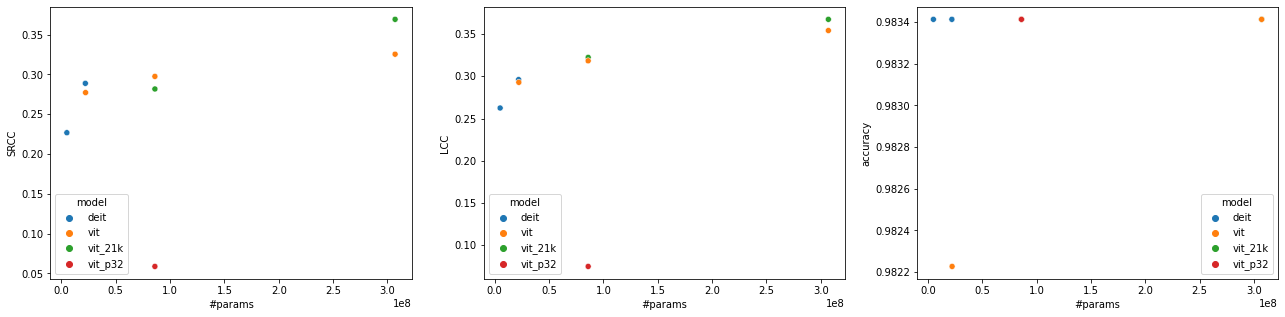

In [14]:
fig, axs = plt.subplots(ncols=3, figsize=(22,5))
sns.scatterplot(data=PCCD[PCCD.scoring=='baseline'], x='#params', y='SRCC', hue='model', ax=axs[0])
sns.scatterplot(data=PCCD[PCCD.scoring=='baseline'], x='#params', y='LCC', hue='model', ax=axs[1])
sns.scatterplot(data=PCCD[PCCD.scoring=='baseline'], x='#params', y='accuracy', hue='model', ax=axs[2])

<AxesSubplot:xlabel='#params', ylabel='accuracy'>

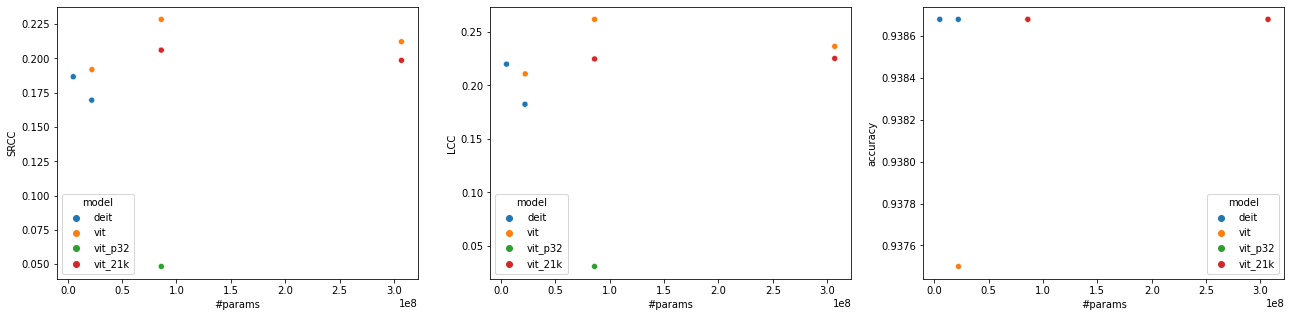

In [15]:
fig, axs = plt.subplots(ncols=3, figsize=(22,5))
sns.scatterplot(data=PCCD[PCCD.scoring=='sentiment'], x='#params', y='SRCC', hue='model', ax=axs[0])
sns.scatterplot(data=PCCD[PCCD.scoring=='sentiment'], x='#params', y='LCC', hue='model', ax=axs[1])
sns.scatterplot(data=PCCD[PCCD.scoring=='sentiment'], x='#params', y='accuracy', hue='model', ax=axs[2])